# Categorical Support Vector Classifier

## Imports

In [18]:
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder 
from sklearn import svm, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, \
f1_score, classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report 

## Loading the database

#### Read the csv file and study the database

In [2]:
mushroom_data = pd.read_csv("mushrooms-full-dataset.csv", dtype = str)
mushroom_data.head()

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
mushroom_data['poisonous'].value_counts()

e    4208
p    3916
Name: poisonous, dtype: int64

In [4]:
mushroom_data.isnull().sum()

poisonous                   0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

## Preprocessing

#### Define the target and the inputs

In [5]:
target = mushroom_data['poisonous']
inputs = mushroom_data.drop(['poisonous'],axis=1)

#### Create a training and a testing dataset

In [6]:
x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=365, stratify = target)

#### Check the result from the stratification

In [7]:
y_train.value_counts(normalize = True)

e    0.517926
p    0.482074
Name: poisonous, dtype: float64

In [8]:
pd.Series(y_test).value_counts(normalize = True)

e    0.518154
p    0.481846
Name: poisonous, dtype: float64

#### Define a separate encoder for the target and the inputs 

In [9]:
enc_i = OrdinalEncoder()
enc_t = LabelEncoder()

#### Apply the fit_transform() method on the training data and the transform() method on the test data.

In [10]:
x_train_transf = enc_i.fit_transform(x_train)
x_test_transf = enc_i.transform(x_test)

y_train_transf = enc_t.fit_transform(y_train)
y_test_transf = enc_t.transform(y_test)

In [11]:
y_train_transf

array([0, 0, 0, ..., 1, 0, 0])

In [12]:
x_train_transf

array([[3., 3., 2., ..., 7., 1., 6.],
       [5., 3., 4., ..., 2., 5., 4.],
       [2., 0., 4., ..., 2., 4., 0.],
       ...,
       [2., 3., 2., ..., 7., 4., 0.],
       [3., 0., 8., ..., 7., 3., 1.],
       [5., 0., 3., ..., 3., 4., 0.]])

## Rescaling

### In order for the SVC to work correctly the inputs need to be rescaled to the range (-1, 1)

In [13]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train_transf)
x_train_rescaled = scaling.transform(x_train_transf)

## Classification

In [14]:
C = 1.0
svc = svm.SVC(kernel='linear', C=C).fit(x_train_rescaled, y_train_transf)

In [15]:
enc_t.classes_

array(['e', 'p'], dtype=object)

### Create a new dataframe with the encoded variables

features_list = data.columns[:-1]
features_list

data_enc = pd.DataFrame(inputs_enc, columns = features_list)
data_enc['poisonous'] = target_enc
data_enc

## Evaluation

#### Evaluate the model on the test data

In [19]:
y_pred_test = svc.predict(scaling.transform(x_test_transf))

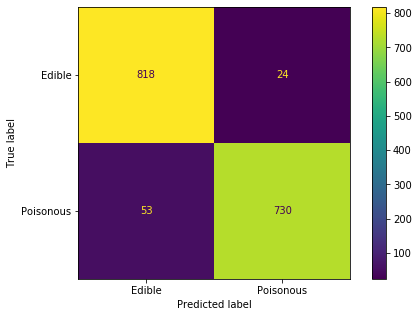

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))

cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test_transf, y_pred_test),
    display_labels=["Edible", "Poisonous"],
)

cmp.plot(ax=ax);

In [31]:
print(classification_report(y_test_transf, y_pred_test, target_names = ["Edible", "Poisonous"]))

              precision    recall  f1-score   support

      Edible       0.94      0.97      0.96       842
   Poisonous       0.97      0.93      0.95       783

    accuracy                           0.95      1625
   macro avg       0.95      0.95      0.95      1625
weighted avg       0.95      0.95      0.95      1625



## Hyperparameter Tuning with GridSearchCV

### Choose the best kernel and optimal C parameter based on Cross Validation of the training data

In [32]:
tuned_parameters = [
    {"kernel": ["linear"], "C": [1, 10]},
    {"kernel": ["poly"], "C":[1, 10]},
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10]}
]

In [33]:
scores = ["precision", "recall"]

In [35]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(x_train_rescaled, y_train_transf)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test_transf, clf.predict(scaling.transform(x_test_transf))
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'kernel': 'poly'}

Grid scores on development set:

0.952 (+/-0.013) for {'C': 1, 'kernel': 'linear'}
0.954 (+/-0.009) for {'C': 10, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 1, 'kernel': 'poly'}
1.000 (+/-0.000) for {'C': 10, 'kernel': 'poly'}
0.927 (+/-0.004) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.894 (+/-0.014) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.948 (+/-0.008) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.927 (+/-0.004) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.0